In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, ElasticNetCV
ols = LinearRegression()
ridge = Ridge()
lasso  = Lasso()
lassocv = LassoCV()
elasticnet = ElasticNet()
elasticnetcv = ElasticNetCV()
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.feature_selection as fs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
baseline_df=pd.read_csv('baseline_df.csv',index_col='Id')
normalized_baseline_df=pd.read_csv('normalized_baseline_df.csv',index_col='Id')
standardized_baseline_df=pd.read_csv('standardized_baseline_df.csv',index_col='Id')

FileNotFoundError: [Errno 2] File b'baseline_df.csv' does not exist: b'baseline_df.csv'

In [118]:
def dummify_column(dataframe,column_name):
    '''
    ### NOTE!!! ### vector operation not working yet!!!! ###
    - dataframe takes the entire dataframe you are working on
    - column_name takes a list of strings, where the strings are the column names
    '''
    for feature in column_name:
        dummified_feature = pd.get_dummies(dataframe.loc[:,feature], prefix=feature, prefix_sep='__',drop_first=True)
        dummified_df = pd.concat([dataframe.drop(feature,axis=1),dummified_feature],axis=1,sort='False')
    return dummified_df

In [119]:
#create month sold dummy variable
MoSold = pd.get_dummies(baseline_df.MoSold, prefix='MoSold', prefix_sep='__')

In [120]:
#Change MoSold to nominal categorical
baseline_df = dummify_column(baseline_df, ['MoSold'])

In [121]:
#replace MoSold with MoSold dummy in standardized and and normalized dfs
normalized_baseline_df = normalized_baseline_df.drop('MoSold', axis=1)
normalized_baseline_df = pd.concat([normalized_baseline_df, MoSold], axis =1)
standardized_baseline_df = standardized_baseline_df.drop('MoSold', axis=1)
standardized_baseline_df = pd.concat([standardized_baseline_df, MoSold], axis =1)

### Functions

In [26]:
#define function to split into train and test sets
def split_sets(dataframe, seed, test_prop=0.3): 
    '''
    - A function that splits specifically the housing data set into train and test sets
    - Requires multiple assignment: trainX, testX, trainY, testY
    ---------------
    - dataframe: dataframe to be split
    - seed: set seed for reproducability
    - test_prop: takes a float - proportion of dataframe that should be allocated to the test set
    '''

    y=dataframe.SalePrice
    X=dataframe.drop('SalePrice', axis=1)

    np.random.seed(seed)
    testIdxes = np.random.choice(range(0,dataframe.shape[0]), size=round(dataframe.shape[0]*test_prop), replace=False)
    trainIdxes = list(set(range(0,dataframe.shape[0])) - set(testIdxes))

    trainX = X.iloc[trainIdxes,:]
    testX  = X.iloc[testIdxes,:]
    trainY = y.iloc[trainIdxes]
    testY  = y.iloc[testIdxes]
    
    return trainX, testX, trainY, testY

In [87]:
def important_coefs_lasso(model, dataframe):
    '''
    - A function that returns non-zero coefficients in order from a lasso model output
    ---------------
    - dataframe: dataframe of model inputs
    - model: model object
    '''
    lassoCoef = pd.Series(model.coef_, index=dataframe.columns)
    lassoCoef=lassoCoef[np.abs(lassoCoef)>0]
    return lassoCoef.sort_values(ascending=False)

In [150]:
def sort_ridge_coefs(model, dataframe):
    ridge_coef = pd.Series(model.coef_, index=dataframe.columns)
    ridge_coef.sort_values(ascending=False)
    order = abs(ridge_coef).sort_values(ascending=False)
    return ridge_coef[order.index]

In [125]:
trainX, testX, trainY, testY = split_sets(normalized_baseline_df, 0, 0.3)

### Lasso Model

#### *Grid Search for Optimal Alpha*

In [126]:
#define alpha range and train lasso model
alphaRange = np.linspace(10e-6,0.05,100)

grid_param=[{'alpha': alphaRange}]
para_search = GridSearchCV(estimator=Lasso(max_iter=5000),\
                           param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.00000e-05, 5.14949e-04, ..., 4.94951e-02, 5.00000e-02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

#### *Visualize Grid Search Results*

Best Test MSE: 0.014228193558174633
Best Alpha: 0.00101989898989899


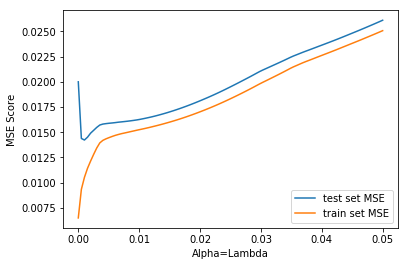

In [127]:
#plot cross validation results
plt.plot(alphaRange,-1*para_search.cv_results_['mean_test_score'], label=r'test set MSE')
plt.plot(alphaRange,-1*para_search.cv_results_['mean_train_score'], label=r'train set MSE')
plt.legend(loc=4)

plt.xlabel('Alpha=Lambda')
plt.ylabel('MSE Score')
lasso_best_score = para_search.best_score_
lasso_best_alpha = para_search.best_params_['alpha']
print('Best Test MSE: %s' %(abs(lasso_best_score)))
print('Best Alpha: %s' %(lasso_best_alpha))

#### *Lasso Results on Test Set*

In [128]:
lasso.set_params(alpha=lasso_best_alpha, normalize = False)
lasso.fit(trainX,trainY)
MSE = np.mean((lasso.predict(testX)-testY)**2)
RMSE_in_dollars = np.mean((np.exp(lasso.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(MSE))
print('Test RMSE in $$: %s' %(RMSE_in_dollars))

Test MSE: 0.011487644111923797
Test RMSE in $$: 15147.53992054188


In [129]:
important_coefs_lasso(lasso, trainX)

SaleType__New            0.098399
GrLivArea                0.094545
Neighborhood__Crawfor    0.084482
OverallQual              0.073172
SaleCondition__Normal    0.062633
YearBuilt                0.059433
Exterior1st__BrkFace     0.054709
CentralAir__Y            0.054003
Neighborhood__Somerst    0.052920
Neighborhood__BrkSide    0.046308
OverallCond              0.045120
Functional__Typ          0.039565
MSZoning__RL             0.033651
TotalBsmtSF              0.033527
Condition1__Norm         0.031758
LotArea                  0.026470
BsmtFullBath             0.022949
LotConfig__CulDSac       0.019489
1stFlrSF                 0.018083
GarageQual               0.017793
LotFrontage              0.016359
FireplaceQu              0.015706
Exterior1st__MetalSd     0.015406
YearRemodAdd             0.014056
GarageArea               0.013953
Foundation__PConc        0.013360
ScreenPorch__1           0.012775
FullBath                 0.012398
EnclosedPorch__1         0.011974
MasVnrType__St

### Ridge Model

#### *Grid Search for Optimal Alpha*

In [137]:
#define alpha range and train lasso model
r_alphaRange = np.linspace(10e-3,100,100)

r_grid_param=[{'alpha': r_alphaRange}]
r_para_search = GridSearchCV(estimator=Ridge(max_iter=5000),\
                           param_grid=r_grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
r_para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.000e-02, 1.020e+00, ..., 9.899e+01, 1.000e+02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

#### *Visualize Grid Search Results*

Best Test MSE: 0.014185866445219285
Best Alpha: 17.180000000000003


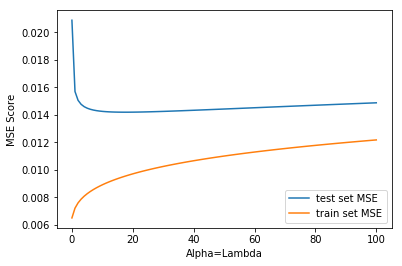

In [138]:
#plot cross validation results
plt.plot(r_alphaRange,-1*r_para_search.cv_results_['mean_test_score'], label=r'test set MSE')
plt.plot(r_alphaRange,-1*r_para_search.cv_results_['mean_train_score'], label=r'train set MSE')
plt.legend(loc=4)

plt.xlabel('Alpha=Lambda')
plt.ylabel('MSE Score')
ridge_best_score = r_para_search.best_score_
ridge_best_alpha = r_para_search.best_params_['alpha']
print('Best Test MSE: %s' %(abs(ridge_best_score)))
print('Best Alpha: %s' %(ridge_best_alpha))

#### *Ridge Results on Test Set*

In [139]:
ridge.set_params(alpha=ridge_best_alpha, normalize = False)
ridge.fit(trainX,trainY)
MSE = np.mean((ridge.predict(testX)-testY)**2)
RMSE_in_dollars = np.mean((np.exp(ridge.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(MSE))
print('Test RMSE in $$: %s' %(RMSE_in_dollars))

Test MSE: 0.012189415902929532
Test RMSE in $$: 15605.000919147584


In [151]:
sort_ridge_coefs(ridge, trainX)

OverallQual                      0.065909
GrLivArea                        0.061758
SaleCondition__Normal            0.060523
Neighborhood__Crawfor            0.060099
YearBuilt                        0.052918
Exterior1st__BrkFace             0.049271
SaleType__New                    0.049051
Neighborhood__IDOTRR            -0.048672
CentralAir__Y                    0.048342
OverallCond                      0.042342
Functional__Typ                  0.041994
Condition1__Norm                 0.039129
Functional__Mod                 -0.038402
1stFlrSF                         0.037115
SaleCondition__Partial           0.037085
Neighborhood__MeadowV           -0.036738
Neighborhood__Somerst            0.036434
Neighborhood__BrkSide            0.036410
MSZoning__RL                     0.036300
BsmtFinType1__Unf               -0.034944
Neighborhood__StoneBr            0.034903
TotalBsmtSF                      0.032809
2ndFlrSF                         0.030635
Neighborhood__NWAmes            -0

### Elastic Net Model

#### *Grid Search for Optimal Alpha*

In [214]:
#define alpha range and train lasso model
alphaSize = 100
rhoSize = 10
e_alphaRange = np.linspace(10e-4, 20, alphaSize)
l1_ratio = np.linspace(0.1, 1, rhoSize)

e_grid_param=[{'alpha': e_alphaRange, 'l1_ratio': l1_ratio}]
e_para_search = GridSearchCV(estimator=ElasticNet(max_iter=2000),\
                           param_grid=e_grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
e_para_search.fit(trainX, trainY)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.0000e-03, 2.0301e-01, ..., 1.9798e+01, 2.0000e+01]), 'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

#### *Output eNet Params*

In [249]:
e_best_alpha = e_para_search.best_params_['alpha']
e_best_l1ratio = list(e_para_search.best_params_.values())[1]
e_best_score = r_para_search.best_score_
print('Best Test MSE: %s' %(abs(e_best_score)))
print('Best Alpha: %s' %(e_best_alpha))
print('Best Rho: %s' %(e_best_l1ratio))

Best Test MSE: 0.014185866445219285
Best Alpha: 0.001
Best Rho: 0.8


#### *eNet Results on Test Set*

In [252]:
elasticnet.set_params(alpha=e_best_alpha, l1_ratio = e_best_l1ratio, normalize = False)
elasticnet.fit(trainX,trainY)
MSE = np.mean((elasticnet.predict(testX)-testY)**2)
RMSE_in_dollars = np.mean((np.exp(elasticnet.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(MSE))
print('Test RMSE in $$: %s' %(RMSE_in_dollars))

Test MSE: 0.011603745491351382
Test RMSE in $$: 15102.589700841503


In [253]:
sort_ridge_coefs(elasticnet, trainX)

SaleType__New                    0.104485
GrLivArea                        0.093416
Neighborhood__Crawfor            0.091460
OverallQual                      0.071104
SaleCondition__Normal            0.066548
Exterior1st__BrkFace             0.064225
YearBuilt                        0.058906
CentralAir__Y                    0.057862
Neighborhood__Somerst            0.057673
Neighborhood__BrkSide            0.048065
Neighborhood__IDOTRR            -0.047249
OverallCond                      0.045055
Functional__Mod                 -0.043296
Functional__Typ                  0.038954
Condition1__Norm                 0.034826
Neighborhood__StoneBr            0.033259
Alley__No Alley                 -0.032182
TotalBsmtSF                      0.032123
BsmtFinType1__Unf               -0.031955
MSZoning__RL                     0.029844
Fence__GdWo                     -0.027797
Neighborhood__MeadowV           -0.027345
LotArea                          0.026832
LotConfig__CulDSac               0